<a href="https://colab.research.google.com/github/RAGHVI27/Deep-learning-based-Chronic-Kidney-Disease-Detection/blob/main/CSE_4020_JCOMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer


df = pd.read_csv('kidney_disease_1.csv')
#df = df.replace(r'^\s*$', np.nan, regex=True)
# Data cleaning and preprocessing
numerical_columns = ['age', 'bp', 'sg', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
#df[numerical_columns] = df[numerical_columns].astype(float)
#imputer = SimpleImputer(strategy='mean')
#df[numerical_columns] = imputer.fit_transform(df[numerical_columns])
# Imputing missing values in numerical columns with mode
numerical_imputer = SimpleImputer(strategy='most_frequent')
df[numerical_columns] = numerical_imputer.fit_transform(df[numerical_columns])

#as done earlier we check and remove typos from the df
df.replace('\t?', np.nan, inplace=True)  # Replace '\t?' with NaN

for col in numerical_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')







In [2]:
# Replacing missing values with the mode for categorical columns
categorical_columns = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [22]:
# Encoding categorical features

df.drop('id', axis=1, inplace=True)
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Standardising numerical features
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

X = df.drop('classification', axis=1)
y = df['classification']

X.fillna(X.mean(), inplace=True)

y = pd.factorize(df['classification'])[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Feature selection using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
sfm = SelectFromModel(rf, threshold=0.1)
sfm.fit(X_train, y_train)
X_train = sfm.transform(X_train)
X_test = sfm.transform(X_test)

In [23]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

X = df.drop(['classification'], axis=1)

X.fillna(X.mean(), inplace=True)

y = pd.factorize(df['classification'])[0]

clf = RandomForestClassifier()
clf.fit(X, y)

feature_importances = clf.feature_importances_
#to print teh feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance
print(feature_importance_df)


   Feature  Importance
11      sc    0.162679
3       al    0.134648
2       sg    0.132747
14    hemo    0.118914
15     pcv    0.106590
5      rbc    0.064574
19      dm    0.042887
18     htn    0.033089
17      rc    0.032092
16      wc    0.028201
10      bu    0.027209
12     sod    0.023762
9      bgr    0.023152
13     pot    0.012927
6       pc    0.012567
1       bp    0.012523
0      age    0.009342
22      pe    0.007322
21   appet    0.006848
4       su    0.004059
20     cad    0.001492
23     ane    0.001359
7      pcc    0.000936
8       ba    0.000080


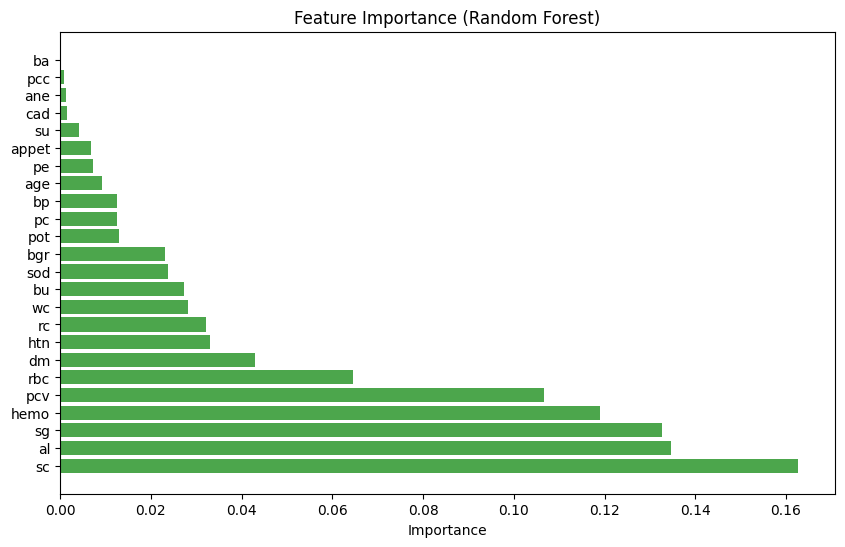

In [24]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='green', alpha=0.7)
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.show()


In [30]:

model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reshape data for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

lstm_output = model.layers[0](X_train)

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

#accuracy = accuracy_score(y_test, y_pred, average='none', zero_division=1)
precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
recall = recall_score(y_test, y_pred, average='macro', zero_division=1)

# Print classification report
print(classification_report(y_test, y_pred))

Epoch 1/10
10/10 [==============================] - 4s 93ms/step - loss: 0.6402 - accuracy: 0.2000 - val_loss: 0.6153 - val_accuracy: 0.1250
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 0.5682 - accuracy: 0.1219 - val_loss: 0.5574 - val_accuracy: 0.1250
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 0.4769 - accuracy: 0.0938 - val_loss: 0.4965 - val_accuracy: 0.1125
Epoch 4/10
10/10 [==============================] - 0s 9ms/step - loss: 0.3770 - accuracy: 0.0781 - val_loss: 0.4405 - val_accuracy: 0.1000
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 0.2568 - accuracy: 0.0812 - val_loss: 0.3947 - val_accuracy: 0.1125
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 0.1402 - accuracy: 0.1000 - val_loss: 0.3626 - val_accuracy: 0.1250
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: -0.0167 - accuracy: 0.1219 - val_loss: 0.2646 - val_accuracy: 0.1500
Epoch 8/10
10/10

3/3 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       1.00      0.44      0.61        52
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00        28

    accuracy                           0.29        80
   macro avg       0.33      0.15      0.20        80
weighted avg       0.65      0.29      0.40        80



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [22]:
print("NaN values in y_pred:", np.isnan(y_pred).any())
print("Inf values in y_pred:", np.isinf(y_pred).any())


NaN values in y_pred: False
Inf values in y_pred: False


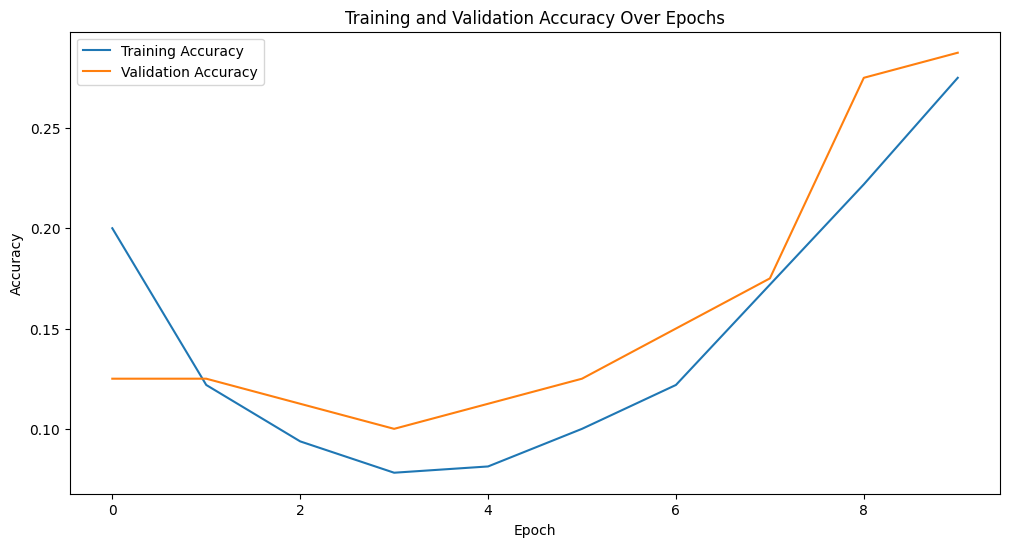

In [31]:

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# New section

In [33]:
from keras.models import Sequential
from keras.layers import GRU, Dense
import tensorflow as tf
tf.experimental.numpy.experimental_enable_numpy_behavior()
# GRU Model
gru_model = Sequential()
gru_model.add(GRU(64, input_shape=(lstm_output.shape[1], 1)))
gru_model.add(Dense(1, activation='sigmoid'))

gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reshape data for GRU
lstm_output_reshaped = lstm_output.reshape(lstm_output.shape[0], lstm_output.shape[1], 1)

history1=gru_model.fit(lstm_output_reshaped, y_train, epochs=10, batch_size=32)
gru_output = gru_model.layers[0](lstm_output_reshaped)

gru_predictions = gru_model.predict(lstm_output_reshaped)
gru_predictions = (gru_predictions > 0.5)

print(classification_report(y_train, gru_predictions))


Epoch 1/10
10/10 [==============================] - 2s 20ms/step - loss: 0.6767 - accuracy: 0.3406
Epoch 2/10
10/10 [==============================] - 0s 19ms/step - loss: 0.6049 - accuracy: 0.0063
Epoch 3/10
10/10 [==============================] - 0s 19ms/step - loss: 0.4990 - accuracy: 0.0063
Epoch 4/10
10/10 [==============================] - 0s 20ms/step - loss: 0.3620 - accuracy: 0.0063
Epoch 5/10
10/10 [==============================] - 0s 21ms/step - loss: 0.3181 - accuracy: 0.0063
Epoch 6/10
10/10 [==============================] - 0s 21ms/step - loss: 0.2725 - accuracy: 0.0063
Epoch 7/10
10/10 [==============================] - 0s 21ms/step - loss: 0.1528 - accuracy: 0.0063
Epoch 8/10
10/10 [==============================] - 0s 19ms/step - loss: -0.1007 - accuracy: 0.0063
Epoch 9/10
10/10 [==============================] - 0s 20ms/step - loss: -0.4836 - accuracy: 0.0688
Epoch 10/10
10/10 [==============================] - 0s 8ms/step
              precision    recall  f1-scor

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
from keras.layers import SimpleRNN

#rnn model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(32, input_shape=(gru_output.shape[1], 1)))
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

gru_output_reshaped = gru_output.reshape(gru_output.shape[0], gru_output.shape[1], 1)

rnn_model.fit(gru_output_reshaped, y_train, epochs=10, batch_size=32)

rnn_predictions = rnn_model.layers[0](gru_output_reshaped)

rnn_predictions = rnn_model.predict(gru_output_reshaped)
rnn_predictions = (rnn_predictions > 0.5)

print(classification_report(y_train, rnn_predictions))


Epoch 1/10
10/10 [==============================] - 1s 10ms/step - loss: 0.0504 - accuracy: 0.5469
Epoch 2/10
10/10 [==============================] - 0s 9ms/step - loss: -0.7887 - accuracy: 0.6000
Epoch 3/10
10/10 [==============================] - 0s 9ms/step - loss: -1.2937 - accuracy: 0.6000
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: -1.6280 - accuracy: 0.6031
Epoch 5/10
10/10 [==============================] - 0s 9ms/step - loss: -1.9206 - accuracy: 0.6031
Epoch 6/10
10/10 [==============================] - 0s 10ms/step - loss: -2.1493 - accuracy: 0.6031
Epoch 7/10
10/10 [==============================] - 0s 9ms/step - loss: -2.3661 - accuracy: 0.6031
Epoch 8/10
10/10 [==============================] - 0s 9ms/step - loss: -2.5586 - accuracy: 0.6031
Epoch 9/10
10/10 [==============================] - 0s 10ms/step - loss: -2.7484 - accuracy: 0.6062
Epoch 10/10
10/10 [==============================] - 0s 4ms/step
              precision    recall  f1-sco

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd
# Reshape X_train to 2D array
num_samples, sequence_length, num_features = X_train.shape
X_train_2d = X_train.reshape(num_samples, -1)

# Create a DataFrame
columns = [f'feature_{i}_time_{j}' for i in range(num_features) for j in range(sequence_length)]
df_X_train = pd.DataFrame(X_train_2d, columns=columns)

# Display the DataFrame
print(df_X_train)
# Assuming rnn_predictions contains the output from the RNN model

# Combine the RNN output with the original features
#X_train_combined = pd.concat([X_train, pd.DataFrame(rnn_predictions, columns=['rnn_output'])], axis=1)
#X_test_combined = pd.concat([X_test, pd.DataFrame(rnn_model.predict(X_test_rnn_output), columns=['rnn_output'])], axis=1)

# Convert rnn_predictions to a DataFrame
#rnn_predictions_df = pd.DataFrame(rnn_predictions, columns=['rnn_output'])

# Convert X_train to a DataFrame if it's not already
#if not isinstance(X_train, pd.DataFrame):
    #X_train = pd.DataFrame(X_train, columns=['feature1', 'feature2', ...])  # Replace with your column names
#X_test_rnn_output = rnn_model.predict(X_test)
# Combine the RNN output with the original features
X_train_combined = pd.concat([df_X_train, rnn_predictions_df], axis=1)
#X_test_combined = pd.concat([X_test, pd.DataFrame(rnn_model.predict(rnn_predictions_df), columns=['rnn_output'])], axis=1)
# Convert the predictions to a DataFrame
rnn_test_predictions_df = pd.DataFrame(rnn_model.predict(rnn_predictions_df), columns=['rnn_output'])

# Combine the RNN output with the original features in the test set
#X_test_combined = pd.concat([X_test, rnn_test_predictions_df], axis=1)

# Combine the RNN output with the original features in the test set
X_test_combined = pd.concat([X_test, rnn_test_predictions_df], axis=1)

# to train svm as the meta learner
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}
svm = SVC(random_state=42)

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_combined, y_train)


best_params = grid_search.best_params_
best_kernel = best_params['kernel']
best_C = best_params['C']

# Train the SVM classifier with the best hyperparameters
best_svm = SVC(kernel=best_kernel, C=best_C, random_state=42)
best_svm.fit(X_train_combined, y_train)

y_pred_best_svm = best_svm.predict(X_test_combined)

# Print classification report for the final combined model with the best SVM
print("Best Kernel:", best_kernel)
print("Best C:", best_C)
print(classification_report(y_test, y_pred_best_svm))


     feature_0_time_0  feature_0_time_1  feature_0_time_2  feature_0_time_3  \
0           -2.342354          4.000000          0.143536         -0.580802   
1            1.342766          0.000000         -0.301054         -0.052159   
2            0.421486          1.016949         -0.016517         -1.708574   
3            1.342766          0.000000         -0.318837          0.758426   
4            0.421486          0.000000         -0.407755          0.546969   
..                ...               ...               ...               ...   
315         -1.421074          1.000000          0.054618         -1.074202   
316          0.421486          1.016949          0.552558         -2.413431   
317          1.342766          0.000000         -0.336621          0.511726   
318          0.421486          0.000000         -0.443322          0.265026   
319         -1.421074          0.000000         -0.158785          0.370755   

     feature_0_time_4  
0           -0.885839  
1  

TypeError: ignored

In [35]:
print(X_train)



[[[ 3.00000000e+00]
  [-2.34235440e+00]
  [ 4.00000000e+00]
  [ 1.43535723e-01]
  [-8.85838942e-01]]

 [[ 1.80000000e+01]
  [ 1.34276560e+00]
  [ 0.00000000e+00]
  [-3.01053786e-01]
  [-2.75390345e-01]]

 [[ 2.02000000e+02]
  [ 4.21485600e-01]
  [ 1.01694915e+00]
  [-1.65165002e-02]
  [-1.86255670e+00]]

 ...

 [[ 2.70000000e+02]
  [ 1.34276560e+00]
  [ 0.00000000e+00]
  [-3.36620946e-01]
  [ 2.12968533e-01]]

 [[ 3.48000000e+02]
  [ 4.21485600e-01]
  [ 0.00000000e+00]
  [-4.43322428e-01]
  [ 5.79237692e-01]]

 [[ 1.02000000e+02]
  [-1.42107440e+00]
  [ 0.00000000e+00]
  [-1.58785143e-01]
  [ 1.55595545e+00]]]


In [37]:
"""
import pandas as pd

# Reshape X_train to 2D array
num_samples, sequence_length, num_features = X_train.shape
X_train_2d = X_train.reshape(num_samples, -1)

# Create a DataFrame
columns = [f'feature_{i}_time_{j}' for i in range(num_features) for j in range(sequence_length)]
df_X_train = pd.DataFrame(X_train_2d, columns=columns)

# Display the DataFrame
print(df_X_train)
"""

     feature_0_time_0  feature_0_time_1  feature_0_time_2  feature_0_time_3  \
0                 3.0         -2.342354          4.000000          0.143536   
1                18.0          1.342766          0.000000         -0.301054   
2               202.0          0.421486          1.016949         -0.016517   
3               250.0          1.342766          0.000000         -0.318837   
4               274.0          0.421486          0.000000         -0.407755   
..                ...               ...               ...               ...   
315              71.0         -1.421074          1.000000          0.054618   
316             106.0          0.421486          1.016949          0.552558   
317             270.0          1.342766          0.000000         -0.336621   
318             348.0          0.421486          0.000000         -0.443322   
319             102.0         -1.421074          0.000000         -0.158785   

     feature_0_time_4  
0           -0.885839  
1  

In [42]:
print(X_test_rnn_output.shape)


(80, 1)
